In [38]:
import scanpy as sc
import os
import requests
import gzip
import shutil
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd

In [39]:
from celldreamer.paths import DATA_DIR

Read dataset 

In [40]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        gz_path = path + '.gz'  # Temporary path for the compressed file
        response = requests.get(url, stream=True)

        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(gz_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")

        print("Download complete. Decompressing the file...")

        # Decompress the .gz file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        os.remove(gz_path)  # Remove the compressed file
        print("Decompression complete.")

    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'neurips.h5ad')
dataset_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE194122&format=file&file=GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed%2Eh5ad%2Egz'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Save counts 

In [41]:
adata.layers["X_counts"] = adata.layers["counts"].copy()
del adata.layers["counts"]

Split full transcriptome and hvg 

In [42]:
adata_full = adata.copy()

In [43]:
sc.pp.filter_genes(adata_full, min_cells=10)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HVG selection

In [44]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=True,
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Preprocess

In [45]:
sc.pp.log1p(adata)
sc.pp.log1p(adata_full)

In [46]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.tl.pca(adata_full)
sc.pp.neighbors(adata_full)
sc.tl.umap(adata_full)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


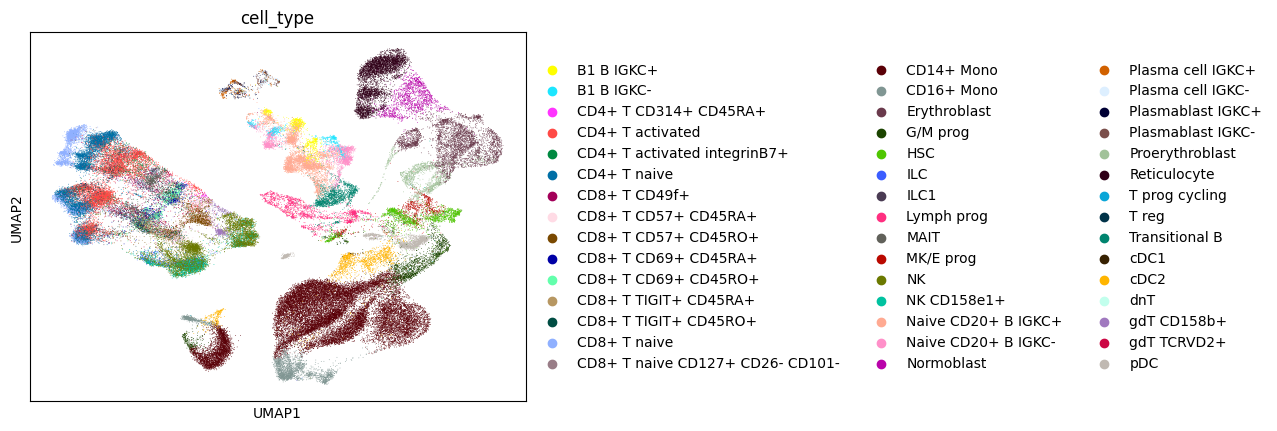

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


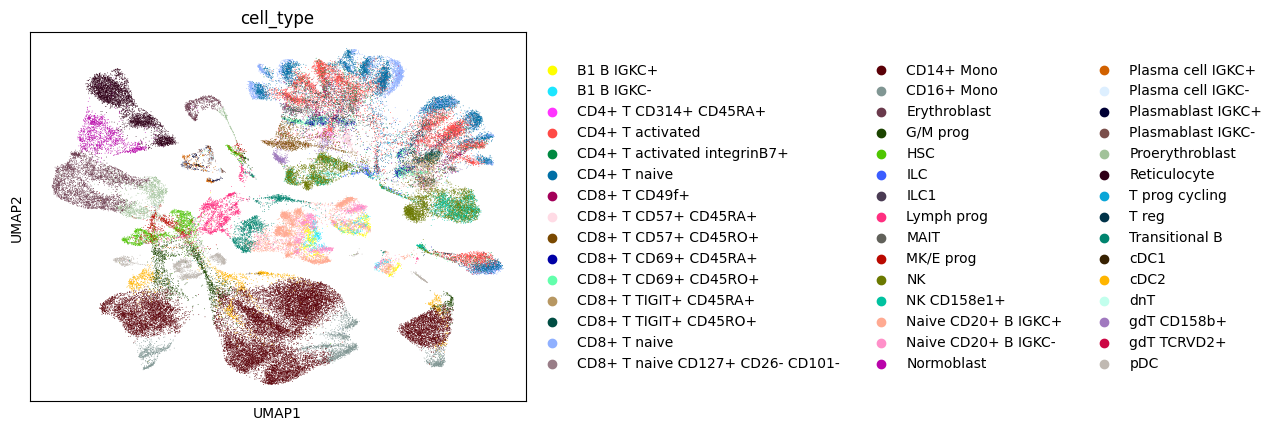

In [47]:
sc.pl.umap(adata, color=["cell_type"])
sc.pl.umap(adata_full, color=["cell_type"])

Save

In [49]:
processed_dataset_path = os.path.join(DATA_DIR, 'processed', 'neurips.h5ad')

ad.write_h5ad(adata, processed_dataset_path)

In [50]:
processed_dataset_path_full = os.path.join(DATA_DIR, 'processed_full_genome', 'neurips.h5ad')

ad.write_h5ad(adata_full, processed_dataset_path_full)